# b jet efficiencies

To account for differences in modelling of b tagging algorithms in data vs. MC, it is important to correct the MC to the data.  The b tag POG provides data/MC scale factors, but it is necessary for analyzers to calculate their own b tag efficiencies in MC since they will depend on both the composition of the sample under consideration and the selection that is applied.

For this study we'll be using the summer 2016, 13 TeV MC production.  The samples considered here will be $t\bar{t}$ and Drell-Yan.  The selection requirement is basically a semileptonic ttbar selection:

* the IsoMu24/IsoTkMu24 trigger must have fired
* there must be at least one good PV
* at least one tight ID, tight PF isolated muons
* lead muon $p_{T} > 25$ and $|\eta| < 2.4$
* four PF jets

The jet that is used for measuring the efficiencies is reconstructed using the anti-$k_{T}$ algorithm and clustering particle-flow objects within a cone of size dR=0.4.  The jet flavor is determined by matching a reconstructed PF jet to a jet that has been reconstructed by clustering generator level partons ([CMS flavor matching scheme](https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideBTagMCTools#Hadron_parton_based_jet_flavour)).  

The definition for our denominator object is:

* PF jet with $p_{T} > 30$ and $|\eta| < 2.4$
* MC flavor is 5 or -5 (PDG ID for a b quark)

The numerator object is a denominator object with the additional requirement that:

* b tag > 0.9432 (tight b tag POG WP for the bMVA discriminator)

The measurement is carried out on both a Z+jet and ttbar sample.  Both the leading and trailing b tagged jets will be considered.  It will be of interest to measure the efficiency as both a function of $p_{T}$ and $\eta$.

In [1]:
# imports and initial configuration
%cd '/home/naodell/work/wbr/analysis'
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import beta

import scripts.plot_tools as pt
from skhep.modeling import bayesian_blocks

matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.labelsize': 20,
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [2]:
# get the datasets
ntuple_dir  = 'data/flatuples/btag_eff/mu4j_2016'
datasets    = [
               'ttbar_inclusive',
               'zjets_m-50', 'zjets_m-10to50',
               'z1jets_m-50', 'z1jets_m-10to50',
               'z2jets_m-50', 'z2jets_m-10to50',
               'z3jets_m-50', 'z3jets_m-10to50',
               'z4jets_m-50', 'z4jets_m-10to50',
              ]
features = [
            'jet1_pt', 'jet1_eta', 'jet1_flavor', 'jet1_tag',
            'jet2_pt', 'jet2_eta', 'jet2_flavor', 'jet2_tag',
            'jet3_pt', 'jet3_eta', 'jet3_flavor', 'jet3_tag',
            'jet4_pt', 'jet4_eta', 'jet4_flavor', 'jet4_tag',
           ]
cuts        = 'lepton1_pt > 25 and abs(lepton1_eta) < 2.4'
#cuts        = 'lepton1_pt > 25 and abs(lepton1_eta) < 2.4 \
#               and lepton2_pt > 10 and abs(lepton2_eta) < 2.4 \
#               and lepton1_q != lepton2_q'

btag_cut = 0.9432
labels = ['ttbar', 'zjets']
fmts   = {'ttbar': 'C0o', 'zjets': 'C1o'}
data_manager = pt.DataManager(input_dir     = ntuple_dir,
                              dataset_names = datasets,
                              selection     = 'mumu',
                              period        = 2016,
                              cuts          = cuts,
                              features      = features
                             )

Loading dataframes: 100%|███████████████| 11.0/11.0 [01:04<00:00, 5.82s/it]


In [3]:
# b tag values for different jet flavors
df = data_manager.get_dataframes(['ttbar', 'zjets'], concat=True)

cnames = ['jet_pt', 'jet_eta', 'jet_tag', 'jet_flavor', 'label']
data = pd.DataFrame(columns=cnames)
for i in range(1,5):
    jet_data = df[[f'jet{i}_pt', f'jet{i}_eta', f'jet{i}_tag', f'jet{i}_flavor', 'label']]
    jet_data.columns = cnames
    data = data.append(jet_data, ignore_index=True)
    

Let's take a look at the b tag values:

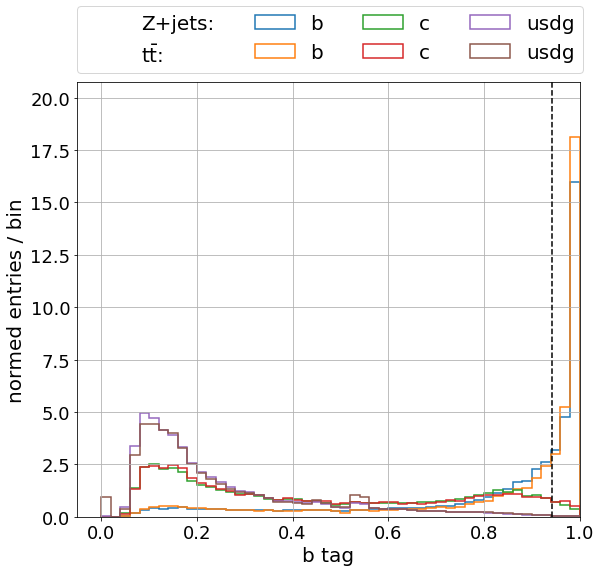

In [4]:
# plot the b tag discriminator
fig, ax = plt.subplots(1, 1, figsize=(9,8), facecolor='white')
h1, b, _ = ax.hist(data.query('label == "ttbar" and jet_flavor == 5').jet_tag, bins=50, range=(0, 1), histtype='step', linewidth=1.5, normed=True, label='b')
h4, b, _ = ax.hist(data.query('label == "zjets" and jet_flavor == 5').jet_tag, bins=50, range=(0, 1), histtype='step', linewidth=1.5, normed=True, label='b')

h2, b, _ = ax.hist(data.query('label == "ttbar" and jet_flavor == 4').jet_tag, bins=50, range=(0, 1), histtype='step', linewidth=1.5, normed=True, label='c')
h5, b, _ = ax.hist(data.query('label == "zjets" and jet_flavor == 4').jet_tag, bins=50, range=(0, 1), histtype='step', linewidth=1.5, normed=True, label='c')

h3, b, _ = ax.hist(data.query('label == "ttbar" and jet_flavor == 0').jet_tag, bins=50, range=(0, 1), histtype='step', linewidth=1.5, normed=True, label='usdg')
h6, b, _ = ax.hist(data.query('label == "zjets" and jet_flavor == 0').jet_tag, bins=50, range=(0, 1), histtype='step', linewidth=1.5, normed=True, label='usdg')

ymax = 1.3*np.max(h1)
ax.plot([btag_cut, btag_cut], [0, ymax], 'k--', label='_nolegend_')
ax.set_ylim([0, ymax])
ax.set_xlim([-0.05, 1])
ax.set_xlabel('b tag')
ax.set_ylabel('normed entries / bin')
ax.grid()

handles, l = ax.get_legend_handles_labels()
ph = [plt.plot([], marker='', ls='')[0]]*2
handles = ph + handles
l = ['Z+jets:', r'$\sf t\bar{t}$:'] + l
ax.legend(handles, l, ncol=4, bbox_to_anchor=(0., 1.02, 1., 1.02), loc=3, borderaxespad=0.)

plt.savefig('plots/bmva_mc.pdf')
plt.show()

This distribution looks pretty reasonable.  Keep in mind every event that goes into the above hisogram does have a b quark in the generator process.  Now let's measure the efficiencies.  We'll want a function that will bin the data and calculate the efficiencies, and one that will plot the result.

It's important to handle the errors on the efficiency correctly.  I have adopted the [Clopper-Pearson](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper-Pearson_interval) interval construction and will be using the 68% CL interval for my error bars.

In [12]:
# helper functions
def efficiency_plot(data, var, labels, bins, fmts, cut):
    '''
    Produces efficiency plots
    '''
    label_dict = {'jet_pt':r'$\sf p_{T}$',
                  'jet_eta':r'$\sf \eta$',
                 }
    fig, ax = plt.subplots(1, 1, figsize=(8,8), facecolor='white')
    num_total, den_total = [], []
    eff_max = 0.
    for l in labels:
        df    = data.query(f'label == "{l}"')
        numer = df.query(f'jet_tag > {cut}')[var]
        denom = df[var]
        num_total = np.append(num_total, numer.values)
        den_total = np.append(den_total, denom.values)
        
        x, eff, x_err, y_err = pt.calculate_efficiency(numer.values, denom.values, bins=bins)
        ax.errorbar(x, eff, yerr=y_err, xerr=x_err,
                    fmt=fmts[l],
                    capsize=0,
                    markersize=8.,
                    elinewidth=2
                   )
        if eff.max() > eff_max:
            eff_max = eff.max() 
            
    # calculate efficiency averaged over samples
    #x, eff, x_err, y_err = pt.calculate_efficiency(num_total, 
    #                                               den_total, 
    #                                               bins=bins
    #                                              )
    #ax.errorbar(x, eff, yerr=y_err, xerr=x_err,
    #            fmt='k.-',
    #            capsize=0,
    #            markersize=8.,
    #            elinewidth=2
    #           )
        
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim(0., min(1.5*eff_max, 1.1))
    ax.set_xlabel(label_dict[var])
    ax.set_ylabel(r'$\sf \epsilon_{b\,tag}$')

    ax.legend(labels)
    ax.grid()
    
    return eff

## b tag efficiencies

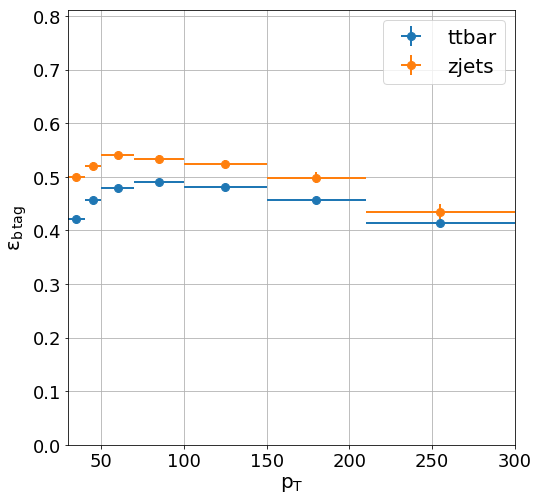

In [13]:
# efficiencies vs. pt
var = 'jet_pt'
pt_bins = [30, 40, 50, 70, 100, 150, 210, 300]
eff = efficiency_plot(data.query('jet_flavor == 5'), var, labels, pt_bins, fmts, btag_cut)

#print(pt_bins, eff, sep='\n')
plt.savefig('plots/bmva_mceff_vs_pt_b.pdf')
plt.show()

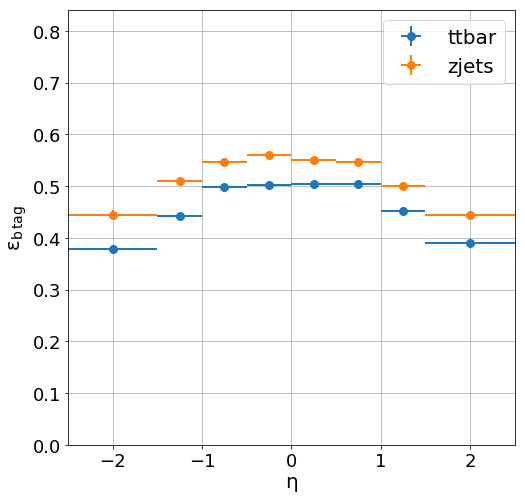

In [14]:
# efficiencies vs. eta
var = 'jet_eta'
eta_bins = [-2.5, -1.5, -1., -0.5, 0., 0.5, 1.0, 1.5, 2.5]
_ = efficiency_plot(data.query('jet_flavor == 5'), var, labels, eta_bins, fmts, btag_cut)

plt.savefig('plots/bmva_mceff_vs_eta_b.pdf')
plt.show()

## c jet efficiencies

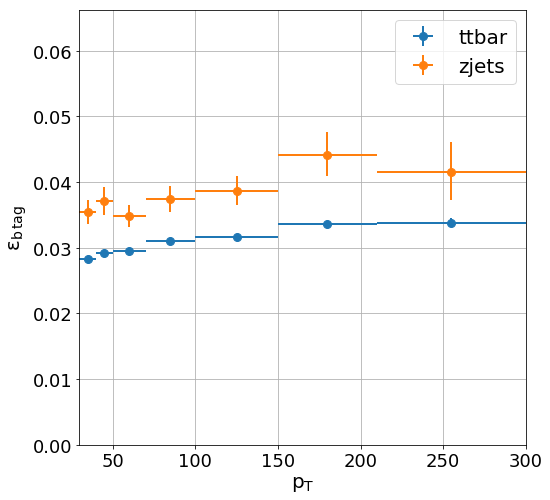

In [15]:
# efficiencies vs. pt
var = 'jet_pt'
eff = efficiency_plot(data.query('jet_flavor == 4'), var, labels, pt_bins, fmts, btag_cut)

#print(pt_bins, eff, sep='\n')
plt.savefig('plots/bmva_mceff_vs_pt_c.pdf')
plt.show()

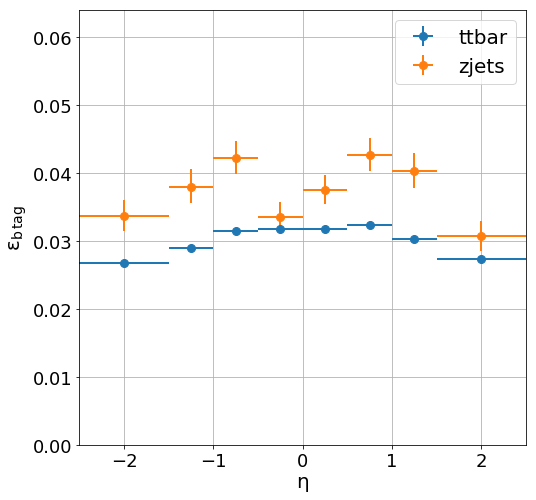

In [16]:
# efficiencies vs. eta
var = 'jet_eta'
_ = efficiency_plot(data.query('jet_flavor == 4'), var, labels, eta_bins, fmts, btag_cut)
plt.savefig('plots/bmva_mceff_vs_eta_c.pdf')
plt.show()

## usdg efficiencies

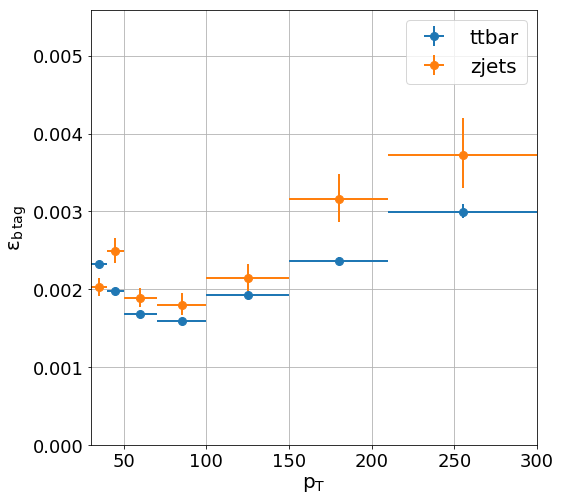

In [17]:
# efficiencies vs. pt
var = 'jet_pt'
eff = efficiency_plot(data.query('jet_flavor == 0'), var, labels, pt_bins, fmts, btag_cut)

#print(pt_bins, eff, sep='\n')
plt.savefig('plots/bmva_mceff_vs_pt_usdg.pdf')
plt.show()

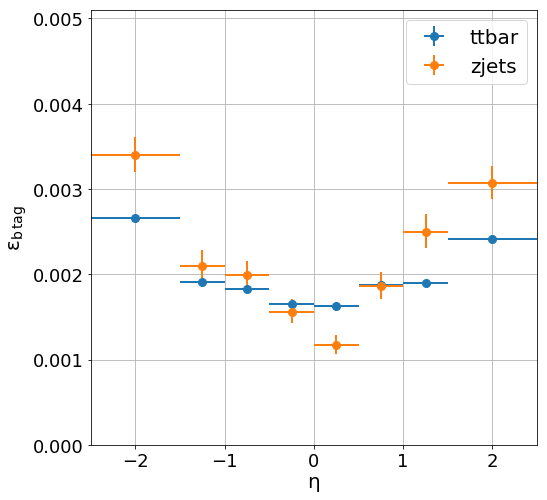

In [18]:
# efficiencies vs. eta
var = 'jet_eta'
efficiency_plot(data.query('jet_flavor == 0'), var, labels, eta_bins, fmts, btag_cut)
plt.savefig('plots/bmva_mceff_vs_eta_usdg.pdf')
plt.show()